###  Cell Painting morphological (CP) and L1000 gene expression (GE) profiles for the following datasets:
 
- **CDRP**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ There are 30,430 unique compounds for CP dataset, median number of replicates --> 4
    * $\bf{GE}$ There are 21,782 unique compounds for GE dataset, median number of replicates --> 3
    * 20,131 compounds are present in both datasets.

- **CDRP-bio**-BBBC036-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ There are 2,242 unique compounds for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 1,917 unique compounds for GE dataset, median number of replicates --> 2
    * 1916 compounds are present in both datasets.

    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ There are 593 unique alleles for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 529 unique alleles for GE dataset, median number of replicates --> 8
    * 525 alleles are present in both datasets.
    
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ There are 323 unique alleles for CP dataset, median number of replicates --> 5
    * $\bf{GE}$ There are 327 unique alleles for GE dataset, median number of replicates --> 2
    * 150 alleles are present in both datasets.
    
- **LINCS**-Pilot1-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ There are 1570 unique compounds across 7 doses for CP dataset, median number of replicates --> 5
    * $\bf{GE}$ There are 1402 unique compounds for GE dataset, median number of replicates --> 3
    * $N_{p/d}$: 6984 compounds are present in both datasets.
--------------------------------------------
 #### Link to the processed profiles:
 
 https://cellpainting-datasets.s3.us-east-1.amazonaws.com/Rosetta-GE-CP

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import os
from cmapPy.pandasGEXpress.parse import parse
from utils.replicateCorrs import replicateCorrs
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile,saveDF_to_CSV_GZ_no_timestamp
from importlib import reload
from utils.normalize_funcs import standardize_per_catX
# sns.set_style("whitegrid")
# np.__version__
pd.__version__

'1.1.1'

###  Input / ouput files:

- **CDRPBIO**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input: .mat files that are generated using https://github.com/broadinstitute/2014_wawer_pnas
        * Output:
    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:
        * Output:
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:  https://data.broadinstitute.org/icmap/custom/TA/brew/pc/TA.OE005_U2OS_72H/
        * Output:
        
### Reformat Cell-Painting Data Sets
- CDRP and TA-ORF are in /storage/data/marziehhaghighi/Rosetta/raw-profiles/
- Luad is already processed by Juan, source of the files is at /storage/luad/profiles_cp
 in case you want to reformat

In [2]:
fileName='RepCorrDF'
### dirs on gpu cluster
# rawProf_dir='/storage/data/marziehhaghighi/Rosetta/raw-profiles/'
# procProf_dir='/home/marziehhaghighi/workspace_rosetta/workspace/'

### dirs on ec2
rawProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/'
# procProf_dir='./'
procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
# s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/preprocessed_data
# aws s3 sync preprocessed_data s3://cellpainting-datasets/Rosetta-GE-CP/preprocessed_data --profile jumpcpuser

filename='../../results/RepCor/'+fileName+'.xlsx'


In [9]:
# ls ../../
# https://cellpainting-datasets.s3.us-east-1.amazonaws.com/

# CDRP-BBBC047-Bray

### GE - L1000 - CDRP

In [14]:
os.listdir(rawProf_dir+'/l1000_CDRP/')

['Broad.PNAS2014.ProfilingData',
 'cdrp.all.prof.mat',
 'cdrp.cpd.prof.mat',
 'cdrp.well.metadata.mat',
 'cdrp.well.pczscore.mat',
 'cdrp.well.prof.mat',
 'compounds.txt',
 'ge.profiles_n21983x977.gct',
 'ge.profiles_n21983x977.gctx',
 'hts.hitcounts.txt',
 'mc.profiles_n30439x812.gct',
 'mc.profiles_n30439x812.gctx',
 'readme.txt',
 'wawer.gene.all.prof.rds']

In [15]:
cdrp_dataDir=rawProf_dir+'/l1000_CDRP/'
cpd_info = pd.read_csv(cdrp_dataDir+"/compounds.txt", sep="\t", dtype=str)
cpd_info.columns

Index(['BROAD_CPD_ID', 'CPD_NAME', 'CPD_TYPE', 'CPD_SMILES'], dtype='object')

In [16]:
from scipy.io import loadmat
x = loadmat(cdrp_dataDir+'cdrp.all.prof.mat')

k1=x['metaWell']['pert_id'][0][0]
k2=x['metaGen']['AFFX_PROBE_ID'][0][0]
k3=x['metaWell']['pert_dose'][0][0]
k4=x['metaWell']['det_plate'][0][0]
# pert_dose
# x['metaWell']['pert_id'][0][0][0][0][0]
pertID = []
probID=[]
for r in range(len(k1)):
    v = k1[r][0][0]
    pertID.append(v)
#     probID.append(k2[r][0][0])

for r in range(len(k2)):
    probID.append(k2[r][0][0])
    
pert_dose=[]
det_plate=[]
for r in range(len(k3)):
    pert_dose.append(k3[r][0])
    det_plate.append(k4[r][0][0]) 
    
dataArray=x['pclfc'];
cdrp_l1k_rep = pd.DataFrame(data=dataArray,columns=probID)
cdrp_l1k_rep['pert_id']=pertID
cdrp_l1k_rep['pert_dose']=pert_dose
cdrp_l1k_rep['det_plate']=det_plate
cdrp_l1k_rep['BROAD_CPD_ID']=cdrp_l1k_rep['pert_id'].str[:13]
cdrp_l1k_rep2=pd.merge(cdrp_l1k_rep, cpd_info, how='left',on=['BROAD_CPD_ID'])
l1k_features_cdrp=cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains("_at")]
cdrp_l1k_rep2['pert_id_dose']=cdrp_l1k_rep2['BROAD_CPD_ID']+'_'+cdrp_l1k_rep2['pert_dose'].round(2).astype(str)
cdrp_l1k_rep2['pert_sample_dose']=cdrp_l1k_rep2['pert_id']+'_'+cdrp_l1k_rep2['pert_dose'].round(2).astype(str)

# cdrp_l1k_df.head()
print(cpd_info.shape,cdrp_l1k_rep.shape,cdrp_l1k_rep2.shape)

cdrp_l1k_rep2['pert_id_dose']=cdrp_l1k_rep2['pert_id_dose'].replace('DMSO_-666.0', 'DMSO')
cdrp_l1k_rep2['pert_sample_dose']=cdrp_l1k_rep2['pert_sample_dose'].replace('DMSO_-666.0', 'DMSO')

saveDF_to_CSV_GZ_no_timestamp(cdrp_l1k_rep2,procProf_dir+'preprocessed_data/CDRP-BBBC047-Bray/L1000/replicate_level_l1k.csv.gz');
# cdrp_l1k_rep2.head()

(32324, 4) (68120, 981) (68120, 986)


In [23]:
# cpd_info

### CP - CDRP

In [28]:
profileType=['_augmented','_normalized']

bioactiveFlag="";# either "-bioactive" or ""

plates=os.listdir(rawProf_dir+'/CDRP'+bioactiveFlag+'/')
for pt in profileType[1:2]:
    repLevelCDRP0=[]
    for p in plates:
#         repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP/'+p+'/'+p+pt+'.csv'))
        repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP'+bioactiveFlag+'/'+p+'/'+p+pt+'.csv')) #if bioactive
    repLevelCDRP = pd.concat(repLevelCDRP0)
    metaCDRP1=pd.read_csv(rawProf_dir+'/CP_CDRP/metadata/metadata_CDRP.csv')
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    repLevelCDRP2=pd.merge(repLevelCDRP, metaCDRP1, how='left',on=['Metadata_broad_sample'])
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter'].round(0).astype(int).astype(str)
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_pert_id']+'_'+(repLevelCDRP2['Metadata_mmoles_per_liter']*2).round(0).astype(int).astype(str)
    repLevelCDRP2["Metadata_mmoles_per_liter2"]=(repLevelCDRP2["Metadata_mmoles_per_liter"]*2).round(2)
    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter2'].astype(str)

    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_Sample_Dose'].replace('DMSO_0.0', 'DMSO')
    repLevelCDRP2['Metadata_pert_id']=repLevelCDRP2['Metadata_pert_id'].replace(np.nan, 'DMSO')
    
#     repLevelCDRP2.to_csv(procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')

# ,
    if bioactiveFlag:
        dataFolderName='CDRPBIO-BBBC036-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    else:
#         sgfsgf
        dataFolderName='CDRP-BBBC047-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')

    print(metaCDRP1.shape,repLevelCDRP.shape,repLevelCDRP2.shape)

In [27]:
dataFolderName='CDRP-BBBC047-Bray'
cp_feats=repLevelCDRP.columns[repLevelCDRP.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
features_to_remove =find_correlation(repLevelCDRP2[cp_feats], threshold=0.9, remove_negative=False)
repLevelCDRP2_var_sel=repLevelCDRP2.drop(columns=features_to_remove)
saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2_var_sel,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                  '/CellPainting/replicate_level_cp'+'_normalized_variable_selected'+'.csv.gz')

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3167: RuntimeWarning: compression has no effect when passing file-like object as input.
  formatter.save()


In [29]:
# features_to_remove
# features_to_remove
# features_to_remove

In [24]:
repLevelCDRP2['Nuclei_Texture_Variance_RNA_3_0']

0        -0.049139
1         0.045537
2         0.050316
3         0.227802
4         0.338475
            ...   
153381   -0.193311
153382   -0.141267
153383   -0.193537
153384   -0.041124
153385   -0.381476
Name: Nuclei_Texture_Variance_RNA_3_0, Length: 153386, dtype: float64

In [ ]:
# repLevelCDRP2.shape
# cp_scaled.columns[cp_scaled.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()

# CDRP-bio-BBBC036-Bray

### GE - L1000 - CDRPBIO

In [17]:
bioactiveFlag="-bioactive";# either "-bioactive" or ""
plates=os.listdir(rawProf_dir+'/CDRP'+bioactiveFlag+'/')

In [19]:
# plates

In [ ]:
cdrp_l1k_rep2_bioactive=cdrp_l1k_rep2[cdrp_l1k_rep2["pert_sample_dose"].isin(repLevelCDRP2.Metadata_Sample_Dose.unique().tolist())]


In [21]:
cdrp_l1k_rep.det_plate

0        PAC001_U2OS_6H_X1_B1_UNI4445L
1        PAC001_U2OS_6H_X1_B1_UNI4445L
2        PAC001_U2OS_6H_X1_B1_UNI4445L
3        PAC001_U2OS_6H_X1_B1_UNI4445L
4        PAC001_U2OS_6H_X1_B1_UNI4445L
                     ...              
68115    PAC062_U2OS_6H_X2_B1_UNI4445L
68116    PAC062_U2OS_6H_X3_B1_UNI4445L
68117    PAC062_U2OS_6H_X3_B1_UNI4445L
68118    PAC062_U2OS_6H_X3_B1_UNI4445L
68119    PAC062_U2OS_6H_X3_B1_UNI4445L
Name: det_plate, Length: 68120, dtype: object

### CP - CDRPBIO

In [ ]:
profileType=['_augmented','_normalized','_normalized_variable_selected']

bioactiveFlag="-bioactive";# either "-bioactive" or ""

plates=os.listdir(rawProf_dir+'/CDRP'+bioactiveFlag+'/')
for pt in profileType:
    repLevelCDRP0=[]
    for p in plates:
#         repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP/'+p+'/'+p+pt+'.csv'))
        repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP'+bioactiveFlag+'/'+p+'/'+p+pt+'.csv')) #if bioactive
    repLevelCDRP = pd.concat(repLevelCDRP0)
    metaCDRP1=pd.read_csv(rawProf_dir+'/CP_CDRP/metadata/metadata_CDRP.csv')
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    repLevelCDRP2=pd.merge(repLevelCDRP, metaCDRP1, how='left',on=['Metadata_broad_sample'])
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter'].round(0).astype(int).astype(str)
#     repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_pert_id']+'_'+(repLevelCDRP2['Metadata_mmoles_per_liter']*2).round(0).astype(int).astype(str)
    repLevelCDRP2["Metadata_mmoles_per_liter2"]=(repLevelCDRP2["Metadata_mmoles_per_liter"]*2).round(2)
    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_broad_sample']+'_'+repLevelCDRP2['Metadata_mmoles_per_liter2'].astype(str)

    repLevelCDRP2['Metadata_Sample_Dose']=repLevelCDRP2['Metadata_Sample_Dose'].replace('DMSO_0.0', 'DMSO')
    repLevelCDRP2['Metadata_pert_id']=repLevelCDRP2['Metadata_pert_id'].replace(np.nan, 'DMSO')
    
#     repLevelCDRP2.to_csv(procProf_dir+'preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')

# ,
    if bioactiveFlag:
        dataFolderName='CDRPBIO-BBBC036-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    else:
        dataFolderName='CDRP-BBBC047-Bray'
        saveDF_to_CSV_GZ_no_timestamp(repLevelCDRP2,procProf_dir+'preprocessed_data/'+dataFolderName+\
                                      '/CellPainting/replicate_level_cp'+pt+'.csv.gz')

    print(metaCDRP1.shape,repLevelCDRP.shape,repLevelCDRP2.shape)

# LUAD-BBBC041-Caicedo

### GE - L1000 - LUAD

In [6]:
os.listdir(rawProf_dir+'/l1000_LUAD/input/')

['TA.Lung_intended_clone_info_150406_confirmations_150407_WT_reference_calls_150420_ref2allele.txt',
 'TA.OE014_A549_96H.map',
 'TA.OE014_A549_96H_ZSPCINF_n2939x22268.gctx',
 'TA.OE015_A549_96H.map',
 'TA.OE015_A549_96H_ZSPCINF_n3006x22268.gctx',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_conn_null.txt',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_rep_null.txt',
 'landmark_probe_ids.grp',
 'lung_control_x_mutation_status.grp']

In [7]:
os.listdir(rawProf_dir+'/l1000_LUAD/output/')

['grp_files_141230',
 'high_rep_A549_8reps_141230.log',
 'high_rep_A549_8reps_141230_COMPZ.MODZ_n529x978.gctx',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x22268.gctx',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx',
 'high_rep_A549_8reps_141230_n529x22268.gctx',
 'high_rep_A549_8reps_141230_sig.info',
 'high_rep_A549_ZSPCINF_141208_n5945x22268.gctx',
 'high_rep_A549_inst_final_141207.txt']

In [8]:
luad_dataDir=rawProf_dir+'/l1000_LUAD/'
luad_info1 = pd.read_csv(luad_dataDir+"/input/TA.OE014_A549_96H.map", sep="\t", dtype=str)
luad_info2 = pd.read_csv(luad_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
luad_info=pd.concat([luad_info1, luad_info2], ignore_index=True)
luad_info.head()

,id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mutation_status,x_not_empty,x_number_orfs_per_gene,x_open_closed,x_orf_numbername,x_preferredgenename,x_protein_match,x_transcriptdb,zmad_ref,zmad_ref_well
0,TA.OE014_A549_96H_X1_B19:A03,b19,r2,"dp52,dp53",A549,25,33,duo,TA.OE014_A549_96H_X1_B19,A03,...,ACAT2_WT.o,-666,2,open,ORF017110.1_TRC317.1,acetoacetyl Coenzyme A thiolase|acetyl-CoA ace...,99.7,NM_005891.2,population,all
1,TA.OE014_A549_96H_X1_B19:A04,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A04,...,EBNA1BP2_WT.o,-666,2,open,ORF006664.1_TRC317.1,EBNA1-binding protein 2|nuclear FGF3 binding p...,100,NM_006824.2,population,all
2,TA.OE014_A549_96H_X1_B19:A05,b19,r2,"dp52,dp53",A549,25,41,duo,TA.OE014_A549_96H_X1_B19,A05,...,BFP,-666,16,open,ORFC00001.1_TRC317.1,BFP,100,BFP.1,population,all
3,TA.OE014_A549_96H_X1_B19:A06,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A06,...,HCRED,-666,16,open,ORFC00002.1_TRC317.1,HcRed,100,HcRed.1,population,all
4,TA.OE014_A549_96H_X1_B19:A07,b19,r2,"dp52,dp53",A549,24,55,duo,TA.OE014_A549_96H_X1_B19,A07,...,ABCB9_WT.c,-666,5,close,ORF024050.1_TRC317.1,ABC transporter 9 protein|ATP-binding cassette...,85.6,NM_001243014.1,population,all


In [9]:
luad_l1k_df = parse(luad_dataDir+"/output/high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx").data_df.T.reset_index()
luad_l1k_df=luad_l1k_df.rename(columns={"cid":"id"})
# cdrp_l1k_df['XX']=cdrp_l1k_df['cid'].str[0]
# cdrp_l1k_df['BROAD_CPD_ID']=cdrp_l1k_df['cid'].str[2:15]
luad_l1k_df2=pd.merge(luad_l1k_df, luad_info, how='inner',on=['id'])
luad_l1k_df2=luad_l1k_df2.rename(columns={"x_mutation_status":"allele"})

l1k_features=luad_l1k_df2.columns[luad_l1k_df2.columns.str.contains("_at")]
luad_l1k_df2['allele']=luad_l1k_df2['allele'].replace('UnTrt', 'DMSO')
print(luad_info.shape,luad_l1k_df.shape,luad_l1k_df2.shape)
saveDF_to_CSV_GZ_no_timestamp(luad_l1k_df2,procProf_dir+'/preprocessed_data/LUAD-BBBC041-Caicedo/L1000/replicate_level_l1k.csv.gz')

(5945, 54) (4232, 979) (4232, 1032)


here3


<IPython.core.display.Javascript object>


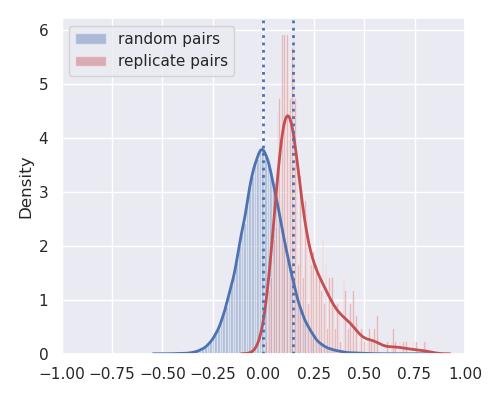

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [10]:
luad_l1k_df_scaled = standardize_per_catX(luad_l1k_df2,'det_plate',l1k_features.tolist());
x_l1k_luad=replicateCorrs(luad_l1k_df_scaled.reset_index(drop=True),'allele',l1k_features,1)
# x_l1k_luad=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='DMSO'].reset_index(drop=True),'allele',l1k_features,1)
# saveAsNewSheetToExistingFile(filename,x_l1k_luad[2],'l1k-luad')

### CP - LUAD

In [ ]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/')
for pt in profileType[1:2]:
    repLevelLuad0=[]
    for p in plates:
        repLevelLuad0.append(pd.read_csv('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/'+p+'/'+p+pt+'.csv'))
    repLevelLuad = pd.concat(repLevelLuad0)
    metaLuad1=pd.read_csv(rawProf_dir+'/CP_LUAD/metadata/combined_platemaps_AHB_20150506_ssedits.csv')
    metaLuad1=metaLuad1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    metaLuad1['Metadata_Well']=metaLuad1['Metadata_Well'].str.lower()
    # metaLuad2=pd.read_csv('~/workspace_rosetta/workspace/raw_profiles/CP_LUAD/metadata/barcode_platemap.csv')
    # Y[Y['Metadata_Well']=='g05']['Nuclei_Texture_Variance_Mito_5_0']
    repLevelLuad2=pd.merge(repLevelLuad, metaLuad1, how='inner',on=['Metadata_Plate_Map_Name','Metadata_Well'])
    repLevelLuad2['x_mutation_status']=repLevelLuad2['x_mutation_status'].replace(np.nan, 'DMSO')
    cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
#     repLevelLuad2.to_csv(procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(repLevelLuad2,procProf_dir+'preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    print(metaLuad1.shape,repLevelLuad.shape,repLevelLuad2.shape)    

In [ ]:
pt=['_normalized']
# Read save data
repLevelLuad2=pd.read_csv('./preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt[0]+'.csv.gz')

# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelLuad2 = repLevelLuad2.interpolate()
repLevelLuad2 = standardize_per_catX(repLevelLuad2,'Metadata_Plate',cp_features.tolist());
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x_cp_luad=replicateCorrs(df1,'x_mutation_status',cp_features,1)
saveAsNewSheetToExistingFile(filename,x_cp_luad[2],'cp-luad')

# TA-ORF-BBBC037-Rohban

### GE - L1000 

In [19]:
taorf_datadir=rawProf_dir+'/l1000_TA_ORF/'
gene_info = pd.read_csv(taorf_datadir+"TA.OE005_U2OS_72H.map.txt", sep="\t", dtype=str)
# gene_info.columns
# TA.OE005_U2OS_72H_INF_n729x22268.gctx
# TA.OE005_U2OS_72H_QNORM_n729x978.gctx
# TA.OE005_U2OS_72H_ZSPCINF_n729x22268.gctx
# TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx
taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx")
# taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_QNORM_n729x978.gctx")
taorf_l1k_df0=taorf_l1k0.data_df
taorf_l1k_df=taorf_l1k_df0.T.reset_index()
l1k_features=taorf_l1k_df.columns[taorf_l1k_df.columns.str.contains("_at")]
taorf_l1k_df=taorf_l1k_df.rename(columns={"cid":"id"})
taorf_l1k_df2=pd.merge(taorf_l1k_df, gene_info, how='inner',on=['id'])
# print(taorf_l1k_df.shape,gene_info.shape,taorf_l1k_df2.shape)
taorf_l1k_df2.head()
# x_genesymbol_mutation
taorf_l1k_df2['pert_id']=taorf_l1k_df2['pert_id'].replace('CMAP-000', 'DMSO')
# compression_opts = dict(method='zip',archive_name='out.csv')  
# taorf_l1k_df2.to_csv(procProf_dir+'preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv.gz',index=False,compression=compression_opts)
saveDF_to_CSV_GZ_no_timestamp(taorf_l1k_df2,procProf_dir+'preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv.gz')
print(gene_info.shape,taorf_l1k_df.shape,taorf_l1k_df2.shape)
# gene_info.head()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3167: RuntimeWarning: compression has no effect when passing file-like object as input.
  formatter.save()


(729, 40) (729, 979) (729, 1018)


In [144]:
taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size().describe()

count    226.000000
mean       3.225664
std        4.009706
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       56.000000
dtype: float64

In [127]:
taorf_l1k_df2.groupby(['pert_id']).size().describe()

count    328.000000
mean       2.222561
std        3.276621
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max       56.000000
dtype: float64

#### Check Replicate Correlation

here3


<IPython.core.display.Javascript object>


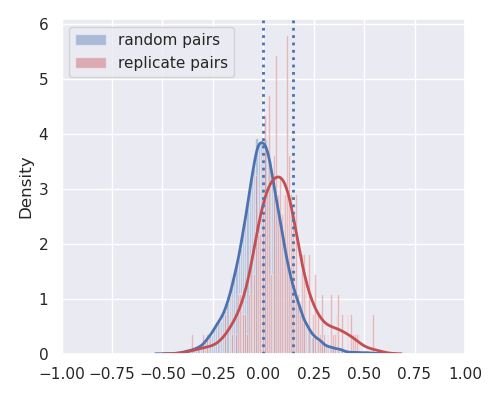

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [274]:
# df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']

df1_scaled = standardize_per_catX(taorf_l1k_df2,'det_plate',l1k_features.tolist());
df1_scaled2=df1_scaled[df1_scaled['pert_id']!='DMSO']
x=replicateCorrs(df1_scaled2,'pert_id',l1k_features,1)

### CP - TAORF

In [11]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir(rawProf_dir+'TA-ORF-BBBC037-Rohban/')
for pt in profileType[0:1]:
    repLevelTA0=[]
    for p in plates:
        repLevelTA0.append(pd.read_csv(rawProf_dir+'TA-ORF-BBBC037-Rohban/'+p+'/'+p+pt+'.csv'))
    repLevelTA = pd.concat(repLevelTA0)
    metaTA1=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA.csv')
    metaTA2=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA_2.csv')
#     metaTA2=metaTA2.rename(columns={"Metadata_broad_sample":"Metadata_broad_sample_2",'Metadata_Treatment':'Gene Allele Name'})
    metaTA=pd.merge(metaTA2, metaTA1, how='left',on=['Metadata_broad_sample'])
#     metaTA2=metaTA2.rename(columns={"Metadata_Treatment":"Metadata_pert_name"})
#     repLevelTA2=pd.merge(repLevelTA, metaTA2, how='left',on=['Metadata_pert_name'])
    repLevelTA2=pd.merge(repLevelTA, metaTA, how='left',on=['Metadata_broad_sample'])

#     repLevelTA2=repLevelTA2.rename(columns={"Gene Allele Name":"Allele"})
    repLevelTA2['Metadata_broad_sample']=repLevelTA2['Metadata_broad_sample'].replace(np.nan, 'DMSO')
    saveDF_to_CSV_GZ_no_timestamp(repLevelTA2,procProf_dir+'/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    print(metaTA.shape,repLevelTA.shape,repLevelTA2.shape)


(323, 4) (1920, 1801) (1920, 1804)


[]


<IPython.core.display.Javascript object>


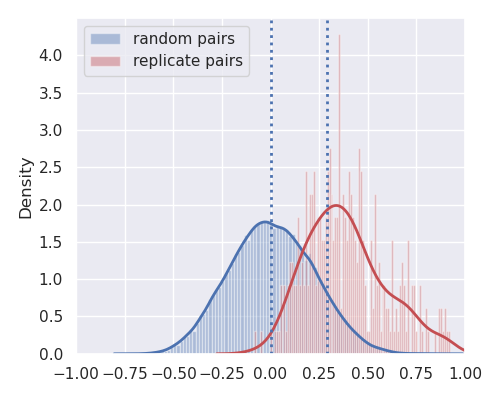

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [12]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelTA2 = standardize_per_catX(repLevelTA2,'Metadata_Plate',cp_features.tolist());
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x_taorf_cp=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)
# saveAsNewSheetToExistingFile(filename,x_taorf_cp[2],'cp-taorf')

In [29]:
# plates

# LINCS-Pilot1

### GE - L1000 - LINCS

In [3]:
os.listdir(rawProf_dir+'/l1000_LINCS/2016_04_01_a549_48hr_batch1_L1000/')

['figures',
 'level_3_q2norm_n27837x978.gctx',
 'level_4W_zspc_n27837x978.gctx',
 'level_4_zspc_n27837x978.gctx',
 'level_5_modz_cid_n9482.grp',
 'level_5_modz_common_sigs_n8370x978.gctx',
 'level_5_modz_n9482x978.gctx',
 'level_5_rank_n9482x978.gctx',
 'steep_nohup.out']

In [210]:
os.listdir(rawProf_dir+'/l1000_LINCS/metadata/')

['REP.A_A549_pert_info.txt',
 'col_meta_level_3_REP.A_A549_only_n27837.txt',
 'col_meta_level_3_n421176.txt',
 'col_meta_level_5_REP.A_A549_only_n9482.txt',
 'col_meta_level_5_n169494.txt',
 'other_cell_lines',
 'set_size_3_level_3_REP.A_A549_only_all_compounds_and_random_well_DMSO.gmt']

In [9]:
data_meta_match_ls=[['level_3','level_3_q2norm_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4W','level_4W_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4','level_4_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_5_modz','level_5_modz_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt'],
                   ['level_5_rank','level_5_rank_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt']]

In [10]:
lincs_dataDir=rawProf_dir+'/l1000_LINCS/'
lincs_pert_info = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
lincs_meta_level3 = pd.read_csv(lincs_dataDir+"/metadata/col_meta_level_3_REP.A_A549_only_n27837.txt", sep="\t", dtype=str)
# lincs_info1 = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
print(lincs_meta_level3.shape)
lincs_meta_level3.head()
# lincs_info2 = pd.read_csv(lincs_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
# lincs_info=pd.concat([lincs_info1, lincs_info2], ignore_index=True)
# lincs_info.head()

(27837, 45)


,distil_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mg_per_ml,x_mmoles_per_liter,x_purity,x_smiles,x_volume_ul,pert_plate,batch,nearest_dose,brew_prefix,group_id
0,REP.A001_A549_24H_X1_B27:A03,b27,r2,"dp52,dp53",A549,39,93,duo,REP.A001_A549_24H_X1_B27,A03,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A03
1,REP.A001_A549_24H_X1_B27:A04,b27,r2,"dp52,dp53",A549,41,67,duo,REP.A001_A549_24H_X1_B27,A04,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A04
2,REP.A001_A549_24H_X1_B27:A05,b27,r2,"dp52,dp53",A549,39,109,duo,REP.A001_A549_24H_X1_B27,A05,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A05
3,REP.A001_A549_24H_X1_B27:A06,b27,r2,"dp52,dp53",A549,38,117,duo,REP.A001_A549_24H_X1_B27,A06,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A06
4,REP.A001_A549_24H_X1_B27:A07,b27,r2,"dp52,dp53",A549,40,89,duo,REP.A001_A549_24H_X1_B27,A07,...,1.10546,10,100,NNC(N)=N,13,REP.A001,REP.A,10,REP.A001_A549_24H,REP.A001_A549_24H:A07


In [12]:
# lincs_meta_level3.groupby('distil_id').size()
lincs_meta_level3['distil_id'].unique().shape

(27837,)

In [44]:
# lincs_meta_level3.columns.tolist()
# lincs_meta_level3.pert_id

In [43]:
ls /home/ubuntu/workspace_rosetta/workspace/software/2018_04_20_Rosetta/preprocessed_data/LINCS-Pilot1/CellPainting

CellPainting/  L1000/


In [7]:
# procProf_dir+'preprocessed_data/LINCS-Pilot1/'
procProf_dir

'./'

In [25]:
for el in data_meta_match_ls:
    lincs_l1k_df=parse(lincs_dataDir+"/2016_04_01_a549_48hr_batch1_L1000/"+el[1]).data_df.T.reset_index()
    lincs_meta0 = pd.read_csv(lincs_dataDir+"/metadata/"+el[2], sep="\t", dtype=str)
    lincs_meta=pd.merge(lincs_meta0, lincs_pert_info, how='left',on=['pert_id'])
    lincs_meta=lincs_meta.rename(columns={"distil_id":"cid"})
    lincs_l1k_df2=pd.merge(lincs_l1k_df, lincs_meta, how='inner',on=['cid'])
    lincs_l1k_df2['pert_id_dose']=lincs_l1k_df2['pert_id']+'_'+lincs_l1k_df2['nearest_dose'].astype(str)
    lincs_l1k_df2['pert_id_dose']=lincs_l1k_df2['pert_id_dose'].replace('DMSO_-666', 'DMSO')
#     lincs_l1k_df2.to_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+el[0]+'.csv.gz',index=False,compression='gzip')
    saveDF_to_CSV_GZ_no_timestamp(lincs_l1k_df2,procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+el[0]+'.csv.gz')

In [31]:
# lincs_l1k_df2

In [22]:
lincs_l1k_rep['pert_id_dose'].unique()

array(['DMSO_-666', 'BRD-K25114078_10', 'BRD-K25114078_3.33', ...,
       'BRD-A97502381_0.12', 'BRD-A97502381_0.04', 'BRD-A95696066_10'],
      dtype=object)

In [11]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[1][0]+'.csv.gz')
# l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
# x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)
# # saveAsNewSheetToExistingFile(filename,x[2],'l1k-lincs')
# # lincs_l1k_rep.head()

In [14]:
lincs_l1k_rep.pert_id.unique().shape

(1403,)

In [51]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains('dose')]

Index(['pert_dose', 'pert_dose_unit', 'pert_idose', 'nearest_dose'], dtype='object')

In [52]:
lincs_l1k_rep[['pert_dose', 'pert_dose_unit', 'pert_idose', 'nearest_dose']]

,pert_dose,pert_dose_unit,pert_idose,nearest_dose
0,-666.000000,-666,-666,-666.00
1,-666.000000,-666,-666,-666.00
2,-666.000000,-666,-666,-666.00
3,-666.000000,-666,-666,-666.00
4,10.000000,um,10 uM,10.00
...,...,...,...,...
27832,3.333330,um,3.33 uM,3.33
27833,1.111110,um,1.11 uM,1.11
27834,0.370370,um,0.37 uM,0.37
27835,0.123457,um,0.12 uM,0.12


In [53]:
lincs_l1k_rep['nearest_dose'].unique()

array([-6.66e+02,  1.00e+01,  3.33e+00,  1.11e+00,  3.70e-01,  1.20e-01,
        4.00e-02,  2.00e+01])

In [218]:
# lincs_l1k_rep.rna_plate.unique()

<IPython.core.display.Javascript object>


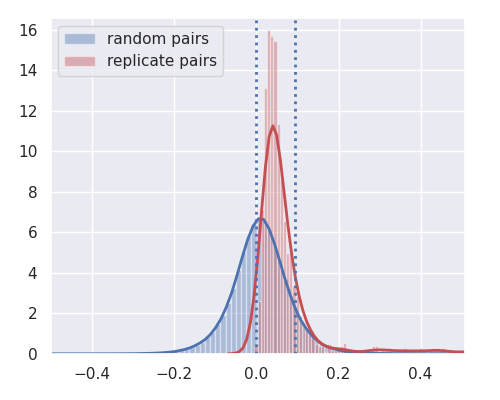

In [59]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)

/home/ubuntu/workspace_rosetta/workspace/software/2018_04_20_Rosetta/utils/replicateCorrs.py:44: RuntimeWarning: Mean of empty slice
  repCorrDf.loc[u,'RepCor']=np.nanmean(repCorr)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


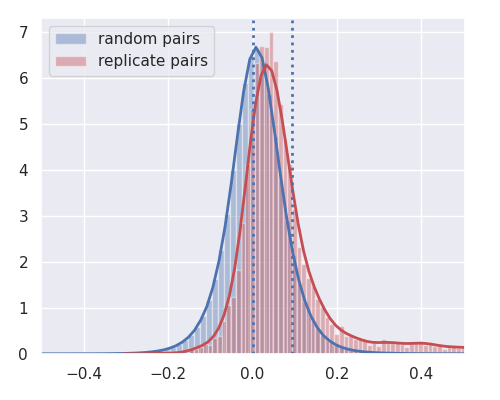

In [58]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x_l1k_lincs=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id_dose',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_lincs[2],'l1k-lincs')

<IPython.core.display.Javascript object>


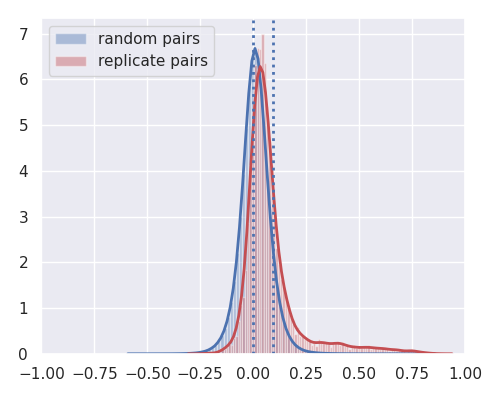

In [20]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
lincs_l1k_rep = standardize_per_catX(lincs_l1k_rep,'det_plate',l1k_features.tolist());
x_l1k_lincs=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id_dose',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x_l1k_lincs[2],'l1k-lincs')

In [220]:
saveAsNewSheetToExistingFile(filename,x[2],'l1k-lincs')

raw data


In [88]:
# set(repLevelLuad2)-set(Y1.columns)

In [100]:
# Y1[['Allele', 'Category', 'Clone ID', 'Gene Symbol']].head()

In [101]:
# repLevelLuad2[repLevelLuad2['PublicID']=='BRDN0000553807'][['Col','InsertLength','NCBIGeneID','Name','OtherDescriptions','PublicID','Row','Symbol','Transcript','Vector','pert_type','x_mutation_status']].head()

#### Check Replicate Correlation

### CP - LINCS

In [65]:
# Ran the following on:
# https://ec2-54-242-99-61.compute-1.amazonaws.com:5006/notebooks/workspace_nucleolar/2020_07_20_Nucleolar_Calico/1-NucleolarSizeMetrics.ipynb
# Metadata
def recode_dose(x, doses, return_level=False):
    closest_index = np.argmin([np.abs(dose - x) for dose in doses])
    if np.isnan(x):
        return 0
    if return_level:
        return closest_index + 1
    else:
        return doses[closest_index]
    
primary_dose_mapping = [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]


metadata=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/CP_LINCS/metadata/matadata_lincs_2.csv")
metadata['Metadata_mmoles_per_liter']=metadata.mmoles_per_liter.values.round(2)
metadata=metadata.rename(columns={"Assay_Plate_Barcode": "Metadata_Plate",'broad_sample':'Metadata_broad_sample','well_position':'Metadata_Well'})

lincs_submod_root_dir="/home/ubuntu/datasetsbucket/lincs-cell-painting/"

profileType=['_augmented','_normalized','_normalized_dmso',\
             '_normalized_feature_select','_normalized_feature_select_dmso']
# profileType=['_normalized']
# plates=metadata.Assay_Plate_Barcode.unique().tolist()
plates=metadata.Metadata_Plate.unique().tolist()
for pt in profileType[4:5]:
    repLevelLINCS0=[]
    
    for p in plates:
        profile_add=lincs_submod_root_dir+"/profiles/2016_04_01_a549_48hr_batch1/"+p+"/"+p+pt+".csv.gz"
        if os.path.exists(profile_add):
            repLevelLINCS0.append(pd.read_csv(profile_add))
            
    repLevelLINCS = pd.concat(repLevelLINCS0)
    meta_lincs1=metadata.rename(columns={"broad_sample": "Metadata_broad_sample"})
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    
    repLevelLINCS2=pd.merge(repLevelLINCS,meta_lincs1,how='left', on=["Metadata_broad_sample","Metadata_Well","Metadata_Plate",'Metadata_mmoles_per_liter'])
    

    repLevelLINCS2 = repLevelLINCS2.assign(Metadata_dose_recode=(repLevelLINCS2.Metadata_mmoles_per_liter.apply(
            lambda x: recode_dose(x, primary_dose_mapping, return_level=False))))
    repLevelLINCS2['Metadata_pert_id_dose']=repLevelLINCS2['Metadata_pert_id']+'_'+repLevelLINCS2['Metadata_dose_recode'].astype(str)
#     repLevelLINCS2['Metadata_Sample_Dose']=repLevelLINCS2['Metadata_broad_sample']+'_'+repLevelLINCS2['Metadata_dose_recode'].astype(str)
    repLevelLINCS2['Metadata_pert_id_dose']=repLevelLINCS2['Metadata_pert_id_dose'].replace(np.nan, 'DMSO')
#     saveDF_to_CSV_GZ_no_timestamp(repLevelLINCS2,procProf_dir+'/preprocessed_data/LINCS-Pilot1/CellPainting/replicate_level_cp'+pt+'.csv.gz')
    print(meta_lincs1.shape,repLevelLINCS.shape,repLevelLINCS2.shape)

(53760, 17) (52223, 1243) (52223, 1257)


In [66]:
# (8120, 15) (52223, 1810) (688699, 1825)
# repLevelLINCS

In [60]:
# pd.merge(repLevelLINCS,meta_lincs1,how='left', on=["Metadata_broad_sample"]).shape
repLevelLINCS.shape,meta_lincs1.shape

((52223, 1810), (53760, 17))

In [ ]:
(8120, 15) (52223, 1238) (52223, 1253)

In [100]:
csv_l1k_lincs=pd.read_csv('./preprocessed_data/LINCS-Pilot1/L1000/replicate_level_l1k'+'.csv.gz')
csv_pddf=pd.read_csv('./preprocessed_data/LINCS-Pilot1/CellPainting/replicate_level_cp'+pt[0]+'.csv.gz')

In [101]:
csv_l1k_lincs.head()

,cid,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,...,nearest_dose,brew_prefix,group_id,nsig,cc_q75,tas_q75,pert_iname_y,pert_type_y,moa,pert_id_dose
0,REP.A001_A549_24H_X1_B27:A03,0.3547,-0.4940,-0.1721,-0.0339,-0.4355,1.8263,-0.1316,0.0853,-0.4660,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A03,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
1,REP.A001_A549_24H_X1_B27:A04,-0.2130,0.4931,-0.8768,-0.6968,-1.7018,-0.3779,-0.6745,-1.9799,-1.1429,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A04,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
2,REP.A001_A549_24H_X1_B27:A05,-0.3280,-0.4555,0.3819,-1.1447,0.0951,-0.5498,-0.6745,-0.0950,-0.2946,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A05,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
3,REP.A001_A549_24H_X1_B27:A06,0.1175,-0.9678,-0.3185,0.4623,-0.2842,-0.9202,-0.8413,0.7160,0.3384,...,-666.0,REP.A001_A549_24H,REP.A001_A549_24H:A06,500,0.180,0.165592,DMSO,ctl_vehicle,Control vehicle,DMSO_-666
4,REP.A001_A549_24H_X1_B27:A07,0.5254,0.0000,-0.4691,0.3652,-1.0688,0.0793,-1.1123,0.1908,-0.8249,...,10.0,REP.A001_A549_24H,REP.A001_A549_24H:A07,6,0.085,0.086878,aminoguanidine,trt_cp,Nitric oxide synthase inhibitor,BRD-K25114078_10


In [104]:
csv_l1k_lincs.pert_id_dose.unique()

array(['DMSO_-666', 'BRD-K25114078_10', 'BRD-K25114078_3.33', ...,
       'BRD-A97502381_0.12', 'BRD-A97502381_0.04', 'BRD-A95696066_10'],
      dtype=object)

In [120]:
csv_pddf.Metadata_pert_id_dose.unique()

array([nan, 'BRD-A62035778_10.0', 'BRD-A62035778_3.33', ...,
       'BRD-K61567297_0.37', 'BRD-K61567297_0.12', 'BRD-K61567297_0.04'],
      dtype=object)

#### Read saved data

In [69]:
repLevelLINCS2.groupby(['Metadata_pert_id']).size()

Metadata_pert_id
BRD-A00147595    24
BRD-A00218260    24
BRD-A00376169    24
BRD-A00546892    24
BRD-A00938334    24
                 ..
BRD-K99964838    30
BRD-M39350793    12
BRD-M80207679    30
BRD-M89827113    30
BRD-M98279124    30
Length: 1570, dtype: int64

In [70]:
repLevelLINCS2.groupby(['Metadata_pert_id_dose']).size().describe()

count    9395.000000
mean        5.558595
std        41.161990
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max      3264.000000
dtype: float64

In [72]:
repLevelLINCS2.Metadata_Plate.unique().shape

(136,)

In [74]:
repLevelLINCS2['Metadata_pert_id_dose'].unique().shape

(9395,)

In [129]:
# csv_pddf['Metadata_mmoles_per_liter'].round(0).unique()
# np.sort(csv_pddf['Metadata_mmoles_per_liter'].unique())

In [141]:
csv_pddf.groupby(['Metadata_dose_recode']).size()#.median()

Metadata_dose_recode
0.04     10954
0.12      7616
0.37      7616
1.11      7616
3.33      7589
10.00     7568
20.00     3264
dtype: int64

['Cells_RadialDistribution_FracAtD_DNA_1of4', 'Cells_RadialDistribution_FracAtD_DNA_2of4', 'Cells_RadialDistribution_FracAtD_DNA_3of4', 'Cells_RadialDistribution_FracAtD_DNA_4of4', 'Cells_RadialDistribution_MeanFrac_DNA_1of4', 'Cells_RadialDistribution_MeanFrac_DNA_2of4', 'Cells_RadialDistribution_MeanFrac_DNA_3of4', 'Cells_RadialDistribution_MeanFrac_DNA_4of4', 'Cells_RadialDistribution_RadialCV_DNA_1of4', 'Cells_RadialDistribution_RadialCV_DNA_2of4', 'Cells_RadialDistribution_RadialCV_DNA_3of4', 'Cells_RadialDistribution_RadialCV_DNA_4of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_1of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_2of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_3of4', 'Cytoplasm_RadialDistribution_FracAtD_DNA_4of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_1of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_2of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_3of4', 'Cytoplasm_RadialDistribution_MeanFrac_DNA_4of4', 'Cytoplasm_RadialDistribution_RadialCV_DNA_1of4', 'Cyto

<IPython.core.display.Javascript object>


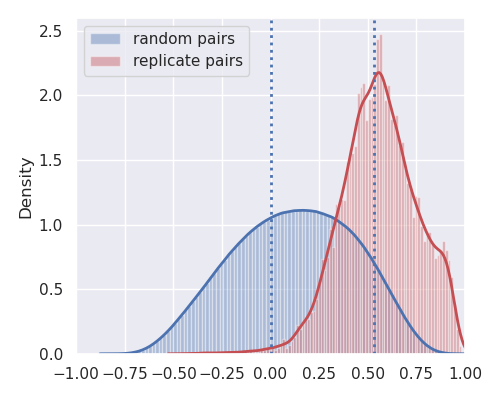

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [8]:
# repLevelLincs2=csv_pddf.copy()
import gc
cp_features=repLevelLincs2.columns[repLevelLincs2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLincs2[i].isnull()).sum(axis=0)/repLevelLincs2.shape[0])>0.05]
print(cols2remove0)
repLevelLincs3=repLevelLincs2.drop(cols2remove0, axis=1);
print('here0')
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
del repLevelLincs2
gc.collect()
print('here0')
cp_features=repLevelLincs3.columns[repLevelLincs3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
repLevelLincs3[cp_features] = repLevelLincs3[cp_features].interpolate()
print('here1')
repLevelLincs3 = standardize_per_catX(repLevelLincs3,'Metadata_Plate',cp_features.tolist());
print('here1')

# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# repSizeDF=repLevelLincs3.groupby(['Metadata_broad_sample']).size().reset_index()
repSizeDF=repLevelLincs3.groupby(['Metadata_pert_id_dose']).size().reset_index()

highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_pert_id_dose.tolist()
highRepComp.remove('DMSO')
# df0=repLevelLincs3[(repLevelLincs3['Metadata_broad_sample'].isin(highRepComp)) &\
#                    (repLevelLincs3['Metadata_dose_recode']==1.11)]
df0=repLevelLincs3[(repLevelLincs3['Metadata_pert_id_dose'].isin(highRepComp))]
x_lincs_cp=replicateCorrs(df0,'Metadata_pert_id_dose',cp_features,1)
# saveAsNewSheetToExistingFile(filename,x_lincs_cp[2],'cp-lincs')

In [5]:
repSizeDF

,Metadata_pert_id_dose,0
0,BRD-A00147595_0.04,4
1,BRD-A00147595_0.12,4
2,BRD-A00147595_0.37,4
3,BRD-A00147595_1.11,4
4,BRD-A00147595_10.0,4
...,...,...
9390,BRD-M98279124_0.37,5
9391,BRD-M98279124_1.11,5
9392,BRD-M98279124_10.0,5
9393,BRD-M98279124_3.33,5


here2


<IPython.core.display.Javascript object>


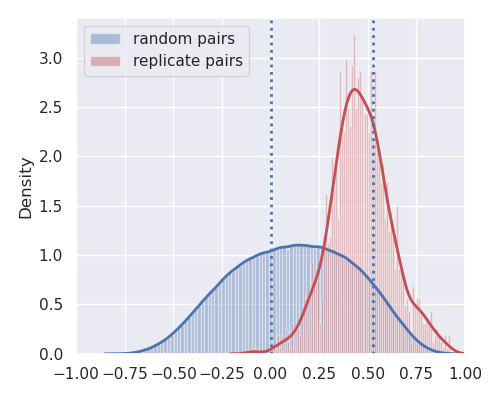

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [18]:
# repLevelLincs2=csv_pddf.copy()

# cp_features=repLevelLincs2.columns[repLevelLincs2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# cols2remove0=[i for i in cp_features if ((repLevelLincs2[i].isnull()).sum(axis=0)/repLevelLincs2.shape[0])>0.05]
# print(cols2remove0)
# repLevelLincs3=repLevelLincs2.drop(cols2remove0, axis=1);
# # cp_features=list(set(cp_features)-set(cols2remove0))
# # repLevelTA2=repLevelTA2.replace('nan', np.nan)
# repLevelLincs3 = repLevelLincs3.interpolate()

# repLevelLincs3 = standardize_per_catX(repLevelLincs3,'Metadata_Plate',cp_features.tolist());

# cp_features=repLevelLincs3.columns[repLevelLincs3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# # df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
# # repSizeDF=repLevelLincs3.groupby(['Metadata_broad_sample']).size().reset_index()
repSizeDF=repLevelLincs3.groupby(['Metadata_pert_id']).size().reset_index()

highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_pert_id.tolist()
# highRepComp.remove('DMSO')
# df0=repLevelLincs3[(repLevelLincs3['Metadata_broad_sample'].isin(highRepComp)) &\
#                    (repLevelLincs3['Metadata_dose_recode']==1.11)]
df0=repLevelLincs3[(repLevelLincs3['Metadata_pert_id'].isin(highRepComp))]
x_lincs_cp=replicateCorrs(df0,'Metadata_pert_id',cp_features,1)
# saveAsNewSheetToExistingFile(filename,x_lincs_cp[2],'cp-lincs')

In [17]:
# x=replicateCorrs(df0,'Metadata_broad_sample',cp_features,1)
# highRepComp[-1]


In [140]:
saveAsNewSheetToExistingFile(filename,x[2],'cp-lincs')

In [168]:
# repLevelLincs3.Metadata_Plate
repLevelLincs3.head()

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,Metadata_pert_id_vendor,Metadata_cell_id,...,Batch_Date,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,alternative_moa,alternative_target,Metadata_dose_recode
0,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A01,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
1,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A02,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
2,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A03,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
3,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A04,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
4,C-7161-01-LM6-018,DMSO,0.0,0.0,DMSO,NaN,NaN,A05,NaN,A549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04


In [127]:
# csv_pddf[(csv_pddf['Metadata_dose_recode']==0.04) & (csv_pddf['Metadata_pert_id']=="BRD-A00147595")][['Metadata_Plate','Metadata_Well']].drop_duplicates()

In [126]:
# csv_pddf[(csv_pddf['Metadata_dose_recode']==0.04) & (csv_pddf['Metadata_pert_id']=="BRD-A00147595") &
#         (csv_pddf['Metadata_Plate']=='SQ00015196') & (csv_pddf['Metadata_Well']=="B12")][csv_pddf.columns[1820:]].drop_duplicates()

In [162]:
# def standardize_per_catX(df,column_name):
column_name='Metadata_Plate'
repLevelLincs_scaled_perPlate=repLevelLincs3.copy()
repLevelLincs_scaled_perPlate[cp_features.tolist()]=repLevelLincs3[cp_features.tolist()+[column_name]].groupby(column_name).transform(lambda x: (x - x.mean()) / x.std()).values

In [ ]:
# def standardize_per_catX(df,column_name):
# # column_name='Metadata_Plate'
#     cp_features=df.columns[df.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
#     df_scaled_perPlate=df.copy()
#     df_scaled_perPlate[cp_features.tolist()]=\
#     df[cp_features.tolist()+[column_name]].groupby(column_name)\
#     .transform(lambda x: (x - x.mean()) / x.std()).values
#     return df_scaled_perPlate

<IPython.core.display.Javascript object>


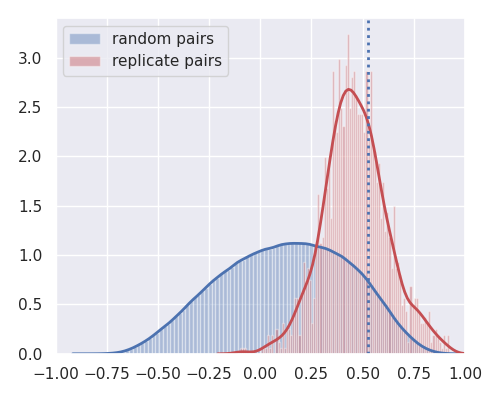

In [163]:
df0=repLevelLincs_scaled_perPlate[(repLevelLincs_scaled_perPlate['Metadata_Sample_Dose'].isin(highRepComp))]
x=replicateCorrs(df0,'Metadata_broad_sample',cp_features,1)